To construct a tabular dataset of timber harvest events from your GeoTIFF raster file while addressing the computational challenges posed by small, isolated pixels, you can follow a step-by-step approach. This method involves data preprocessing, raster manipulation, and vectorization, optimized for efficiency.

Here’s how you can proceed:

1. Clip the Raster to Lane County Boundary

First, clip your raster data to the spatial extent of Lane County, Oregon, to reduce the dataset size and focus on your area of interest.

In [2]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# Load Lane County boundary
folder_path = '/Users/mihiarc/Work/data/'
county_shapefile = folder_path + 'spatial-boundaries/tl_2023_us_county/tl_2023_us_county.shp'
county = gpd.read_file(county_shapefile)
county = county[(county['NAME'] == 'Lane') & (county['STATEFP'] == '41')]  # Filter to Lane County


<Axes: >

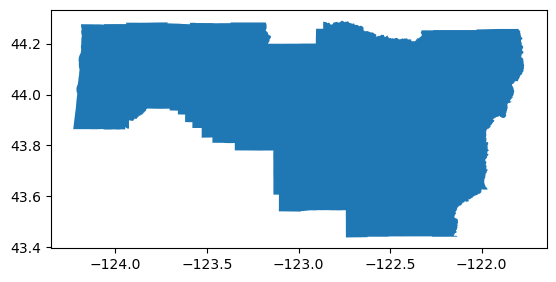

In [4]:
# plot county
county.plot()

In [6]:
# Load the raster
raster_file = folder_path + 'LCMS/LCMS_CONUS_v2023-9-2_Cause_of_Change_Annual_2023/LCMS_CONUS_v2023-9-2_Cause_of_Change_2023.tif'
with rasterio.open(raster_file) as src:
    raster_crs = src.crs
    # Reproject county to match the raster CRS if necessary
    if county.crs != raster_crs:
        county = county.to_crs(raster_crs)

    out_image, out_transform = mask(src, county.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })


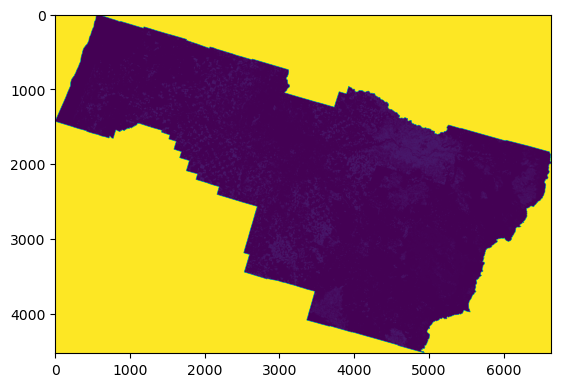

In [7]:
# plot the raster
import matplotlib.pyplot as plt
plt.imshow(out_image[0, :, :])
plt.show()

In [9]:
# Save the clipped raster
clipped_raster = folder_path + 'lane_county_clip.tif'
with rasterio.open(clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)

2. Identify Harvest Pixels

Create a binary raster where harvest pixels (values 4, 5, 6, 7) are set to 1, and all other pixels are set to 0.

In [10]:
import numpy as np

harvest_values = [4, 5, 6, 7]

with rasterio.open(clipped_raster) as src:
    raster_data = src.read(1)
    harvest_mask = np.isin(raster_data, harvest_values).astype(np.uint8)

3. Remove Small Regions

To address the issue of small, isolated pixels, apply morphological operations to remove regions smaller than a specified threshold.

In [11]:
from scipy.ndimage import label, binary_opening, binary_closing, generate_binary_structure

# Define the structure for connectivity (4 or 8)
structure = generate_binary_structure(2, 2)  # 8-connectivity

# Remove small objects (noise)
min_size = 5  # Minimum number of pixels to keep a region
labeled_array, num_features = label(harvest_mask, structure=structure)

# Create an array to store the sizes of each feature
sizes = np.bincount(labeled_array.ravel())
mask_sizes = sizes >= min_size
mask_sizes[0] = 0  # Background should be zero

# Remove small objects
cleaned_mask = mask_sizes[labeled_array]

4. Connected Component Labeling

Label the contiguous regions to identify individual harvest events.

In [12]:
# Re-label the cleaned mask
labeled_array, num_features = label(cleaned_mask, structure=structure)

5. Convert Raster Regions to Polygons

Transform the labeled raster regions into vector polygons.

In [13]:
import rasterio.features
from shapely.geometry import shape

polygons = []
for shape_dict, value in rasterio.features.shapes(labeled_array, transform=src.transform):
    if value > 0:
        geom = shape(shape_dict)
        polygons.append({'geometry': geom, 'properties': {'label': int(value)}})

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(polygons, crs=src.crs)

6. Calculate Area of Harvest Events

Compute the area for each polygon.

In [15]:
# Ensure the GeoDataFrame is in a projected CRS for accurate area calculation
gdf = gdf.to_crs('EPSG:3857')  # Web Mercator projection as an example
gdf['area_m2'] = gdf['geometry'].area

7. Add Attributes

Add the year of harvest and any other relevant attributes.

In [16]:
year_of_harvest = 2023  # Replace with the actual year
gdf['year'] = year_of_harvest

8. Calculate Zonal Statistics (optional)

Use the polygons to calculate zonal statistics from ancillary raster layers (e.g., LCMS landuse/landcover layer).

In [ ]:
# import rasterstats

# ancillary_raster = 'path_to_ancillary_raster.tif'

# # Calculate mean value of the ancillary raster within each polygon
# zonal_stats = rasterstats.zonal_stats(
#     gdf,
#     ancillary_raster,
#     stats=['mean'],
#     geojson_out=True
# )

# # Convert zonal stats to a GeoDataFrame
# zonal_gdf = gpd.GeoDataFrame.from_features(zonal_stats)
# gdf['ancillary_mean'] = zonal_gdf['mean']

9. Filter Out Remaining Small Polygons

If small polygons still exist after the morphological operations, filter them out based on area.

In [17]:
min_area = 1000  # Minimum area in square meters
gdf = gdf[gdf['area_m2'] >= min_area]

10. Export the Final Dataset

Save the resulting GeoDataFrame to a shapefile or any other preferred format.

In [ ]:
output_shapefile = folder_path + 'lcms_harvest_events_2023.shp'
gdf.to_file(output_shapefile)

Optimization Considerations

* Memory Management: Process the data in chunks if it’s too large to fit into memory.
* Parallel Processing: Utilize Python’s multiprocessing library to parallelize tasks.
* Data Types: Use appropriate data types (e.g., np.uint8 instead of np.int32) to reduce memory usage.
* Spatial Indexing: Use spatial indexing with geopandas to speed up spatial operations.

Additional Tips

* Adjust Connectivity: Experiment with 4-connectivity vs. 8-connectivity in the generate_binary_structure function to see which one better captures your harvest events.
* Morphological Operations: You can use binary_opening and binary_closing to remove small objects and fill small holes, respectively.

In [ ]:
from scipy.ndimage import binary_opening, binary_closing

# Remove small objects
cleaned_mask = binary_opening(harvest_mask, structure=structure, iterations=2)
# Fill small holes
cleaned_mask = binary_closing(cleaned_mask, structure=structure, iterations=2)

* Threshold Selection: The min_size and min_area thresholds should be chosen based on domain knowledge about what constitutes a meaningful harvest event.

Scaling Up

Once you have a working pipeline for Lane County and a single year’s data, you can scale up the process:

* Loop Through Years: Iterate over the time series of rasters to process each year.
* Process Multiple Counties: Extend the clipping and processing steps to cover all U.S. counties.
* Automate Workflow: Consider writing functions for each step to automate the pipeline.

References

* [Rasterio Documentation](https://rasterio.readthedocs.io/en/latest/)
* [GeoPandas Documentation](https://geopandas.org/)
* [Rasterstats Documentation](https://pythonhosted.org/rasterstats/)
* [Scipy Ndimage Morphological Operations](https://docs.scipy.org/doc/scipy/reference/ndimage.html)

By following this approach, you should be able to create a manageable and informative polygon layer of harvest events, enriched with relevant attributes and statistics, while mitigating the computational challenges posed by small, isolated pixels.